In [1]:
import pandas as pd
import re
import random
import spacy
import warnings
import matplotlib.pyplot as plt

In [4]:
en_core_web_sm_model = spacy.load('en_core_web_sm')

In [5]:
food_df = pd.read_csv('food.csv')
food_df.head()

,fdc_id,data_type,description,food_category_id,publication_date
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13
4,1105908,branded_food,SWANSON BROTH CHICKEN,NaN,2020-11-13


In [6]:
food_df.shape

(1702235, 5)

In [7]:
foods = food_df[food_df['description'].str.contains('a-zA-Z') == False]['description'].apply(lambda food: food.lower())

In [8]:
foods

0                                 wesson vegetable oil 1 gal
1                                         swanson broth beef
2                   campbell's slow kettle soup clam chowder
3                campbell's slow kettle soup cheese broccoli
4                                      swanson broth chicken
                                 ...                        
1702230    vanilla bean vegan all-in-one protein shake, v...
1702231    smooth chocolate vegan all-in-one protein shak...
1702232    smooth chocolate vegan all-in-one protein shak...
1702233    vanilla bean vegan all-in-one protein shake, v...
1702234      mocha flavored sweetened with monk fruit, mocha
Name: description, Length: 1702234, dtype: object

In [9]:
max_words = lambda x: len(x.split()) if type(x) == str else 0
max_words_in_row = food_df['description'].apply(max_words).max()

In [10]:
max_words_in_row

np.int64(71)

In [11]:
foods = foods[foods.str.split().apply(len) <= 4].drop_duplicates()
foods.size

119954

In [12]:
foods

1                           swanson broth beef
4                        swanson broth chicken
7                    prego sauces tomato basil
8                       campbell's soup tomato
13                pepperidge farm bread tuscan
                          ...                 
1693888    flavorcrisp seasoned diced potatoes
1694146               pork skinless belly 9/11
1694154                         golden nuggets
1694159              pork jowls skinless combo
1694169                   pork sparerib medium
Name: description, Length: 119954, dtype: object

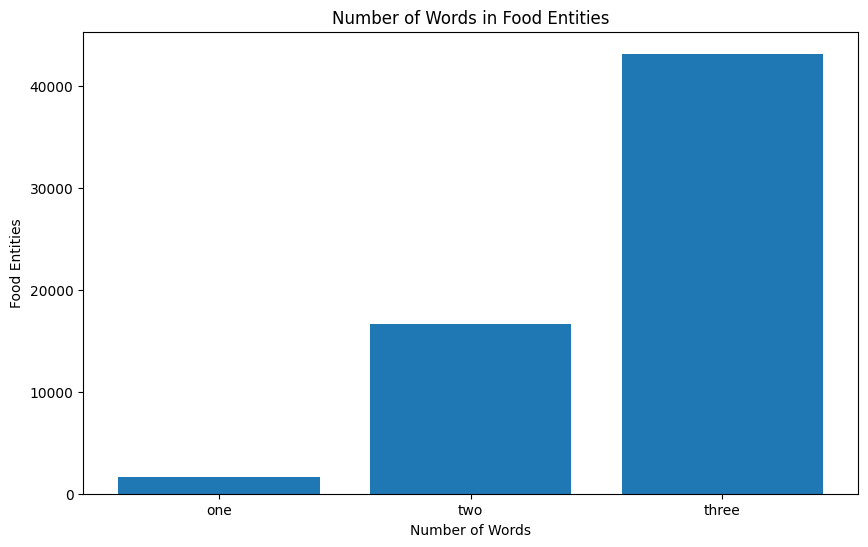

In [13]:
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size  ])

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")
plt.show()

In [14]:
len(one_worded_foods)

1649

In [15]:
len(two_worded_foods)

16673

In [16]:
len(three_worded_foods)

43183

In [17]:
total_num_foods = 30000

two_worded_foods = two_worded_foods.sample(frac=1).reset_index(drop=True)
three_worded_foods = three_worded_foods.sample(frac=1).reset_index(drop=True)

num_one_worded = one_worded_foods.size
remaining_num = total_num_foods - num_one_worded

two_worded_selection = two_worded_foods[:round(remaining_num * 0.50)]
three_worded_selection = three_worded_foods[:round(remaining_num * 0.50)]

foods = pd.concat([one_worded_foods, two_worded_selection, three_worded_selection]).reset_index(drop=True)
foods


0                      blueberries
1                         crackers
2                            dills
3                      cocoa-cakes
4                            adobo
                   ...            
29996         bar-b-q rub, bar-b-q
29997     freeze-dried pear crisps
29998      genuine chocolate syrup
29999    syrup, chocolate hazelnut
30000         danish, almond bites
Name: description, Length: 30001, dtype: object

In [18]:
food_templates = [
  "Order this {}.",
  "Take my order: {}, {}, and {}.",
  "Get me a {}.",
  "Add {} and {} to my order.",
  "Place an order for {}.",
  "I want {}, {}.",
  "Bring me a {}.",
  "Let me have {}.",
  "Get {}, {}, {} for me.",
  "I’ll take {}.",
  "Just give me a {}.",
  "Add this {}, {}.",
  "Order {} and {}.",
  "Grab me a {}.",
  "Can I get a {}?",
  "I’d like to have a {}.",
  "Add a {} to my order, please.",
  "I feel like eating a {}, can you add that?",
  "Do you have a {}? If yes, I’ll take one.",
  "A {} sounds good, can I order one?",
  "I’ll take a {} with extra cheese.",
  "Can I add a {} to my meal?",
  "I’ll have a {}, thanks.",
  "Throw in a {} for me too, please.",
  "I’d like to place an order for a {}.",
  "Could you please add a {} to my order?",
  "May I have a {} with a side of {}?",
  "I’d appreciate it if you could bring me a {}.",
  "Could you recommend something with {}?",
  "I'd love a {}, if it’s available.",
  "Can I have a {} prepared for takeout, please?",
  "I’d like to order a {}, with {} on the side.",
  "Could you add {} to my cart/order?",
  "Please include a {} with my order.",
  "I’ve been craving a {}, can you add that?",
  "A {} sounds perfect right now, I’ll have one.",
  "I’ve been wanting to try your {}, can you add it?",
  "Do you have any specials with {}? If so, I’d like one.",
  "I’m really in the mood for a {}, could you prepare that?",
  "Can I get a {} with no onions?",
  "Do you offer a {} with gluten-free options?",
  "Is it possible to make the {} extra spicy?",
  "Can I have the {} without cheese, please?",
  "Can I customize my {} with extra toppings?",
  "Can you suggest a {} with less sugar?",
  "I’d like a {}, but can you make it vegan?",
  "Does the {} come with sides, or do I need to order separately?",
  "Can I replace {} with {} in my order?",
  "I need {} {} for my group.",
  "Can I order a family pack of {}?",
  "I’d like three {}, two {}, and one {}.",
  "We’re hosting an event, so I’d like to order {}.",
  "Can you handle a bulk order for {}? I need {} of them.",
  "I changed my mind about the {}, can you remove it?",
  "Please cancel my order for the {}.",
  "I no longer want the {} in my order.",
  "Can you take out the {} and add a {} instead?",
  "Remove the {} from my list, I don’t need it.",
  "I’d like to cancel the {}, thanks.",
  "Could you update my order to exclude the {}?",
  "I’m skipping the {} for now, please remove it.",
  "Does my order include a {}?",
  "Can you confirm if the {} is available?",
  "Will my {} be delivered fresh?",
  "How long will it take to prepare the {}?",
  "Is the {} still on the menu?",
  "Are you sure my {} has been added to the order?",
  "Can I check if you’ve added {} to my cart?",
]

In [45]:
train_food_data = {
    "one_food": [],
    "two_foods": [],
    "three_foods": [],
}

test_food_data = {
    "one_food": [],
    "two_foods": [],
    "three_foods": [],
}

food_sentence_limit = 1000

def get_food_data(count):
    return {
        1: train_food_data["one_food"] if len(train_food_data["one_food"]) < food_sentence_limit else test_food_data["one_food"],
        2: train_food_data["two_foods"] if len(train_food_data["two_foods"]) < food_sentence_limit else test_food_data["two_foods"],
        3: train_food_data["three_foods"] if len(train_food_data["three_foods"]) < food_sentence_limit else test_food_data["three_foods"] 
    }[count]

pattern_to_replace = "{}"

foods = foods.sample(frac=1)

food_entity_count = foods.size - 1

while food_entity_count >= 2:
    entities = []

    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    matches = re.findall(pattern_to_replace, sentence)

    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        sentence = sentence.replace(match, food, 1)
        match_span = re.search(re.escape(food), sentence)
        match_span = match_span.span()
        
        entities.append((match_span[0], match_span[1], "FOOD"))

    get_food_data(len(matches)).append((sentence, {"entities": entities}))

In [46]:
train_food_data

{'one_food': [('Can I get a golden oolong tea with no onions?',
   {'entities': [(12, 29, 'FOOD')]}),
  ('Does my order include a sliced hamburger dills?',
   {'entities': [(24, 46, 'FOOD')]}),
  ('Just give me a dark chocolate morsels.', {'entities': [(15, 37, 'FOOD')]}),
  ('Do you offer a whole shiitake mushrooms with gluten-free options?',
   {'entities': [(15, 39, 'FOOD')]}),
  ('Please cancel my order for the liquid creamer.',
   {'entities': [(31, 45, 'FOOD')]}),
  ('I’ll take a homemade kefir with extra cheese.',
   {'entities': [(12, 26, 'FOOD')]}),
  ("I’ve been wanting to try your red decorator's icing, can you add it?",
   {'entities': [(30, 51, 'FOOD')]}),
  ('Can I have the grass fed quark without cheese, please?',
   {'entities': [(15, 30, 'FOOD')]}),
  ('I’d like to cancel the rizogalo, thanks.',
   {'entities': [(23, 31, 'FOOD')]}),
  ('Please cancel my order for the organic zucchini.',
   {'entities': [(31, 47, 'FOOD')]}),
  ('I feel like eating a brookfarm, macadamia

In [47]:
len(train_food_data)

3

In [48]:
len(train_food_data['one_food'])

1000

In [49]:
len(train_food_data['two_foods'])

1000

In [50]:
len(train_food_data['three_foods'])

1000

In [51]:
for key in train_food_data:
    print("{} {} sentences: {}".format(len(train_food_data[key]), key, train_food_data[key][0]))

1000 one_food sentences: ('Can I get a golden oolong tea with no onions?', {'entities': [(12, 29, 'FOOD')]})
1000 two_foods sentences: ('I need whole button sour stars for my group.', {'entities': [(7, 19, 'FOOD'), (20, 30, 'FOOD')]})
1000 three_foods sentences: ('Take my order: organic apricot, cherry ice, cherry, and hot italian sausage.', {'entities': [(15, 30, 'FOOD'), (32, 50, 'FOOD'), (56, 75, 'FOOD')]})


In [52]:
for key in test_food_data:
    print("{} {} items: {}".format(len(test_food_data[key]), key, test_food_data[key][0]))

18699 one_food items: ('I’ll have a spearmint starlights candies, thanks.', {'entities': [(12, 40, 'FOOD')]})
2572 two_foods items: ('May I have a stuffing mix, turkey with a side of cranberry orange cookies?', {'entities': [(13, 33, 'FOOD'), (49, 73, 'FOOD')]})
52 three_foods items: ('Take my order: sauce mix, hollandaise, honey cashews, and gummi treats.', {'entities': [(15, 37, 'FOOD'), (39, 52, 'FOOD'), (58, 70, 'FOOD')]})


In [53]:
npr_df = pd.read_csv("npr.csv")
npr_df.head()

,Article
0,"In the Washington of 2016, even when the polic..."
1,Donald Trump has used Twitter — his prefe...
2,Donald Trump is unabashedly praising Russian...
3,"Updated at 2:50 p. m. ET, Russian President Vl..."
4,"From photography, illustration and video, to d..."


In [54]:
revision_texts = []

for doc in en_core_web_sm_model.pipe(npr_df["Article"][:6000], batch_size=30, disable=["tagger", "ner"]):
    for sentence in doc.sents:
        if  40 < len(sentence.text) < 80:
            revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/c7/1v5wlgds2rjfw4_ldh17bj3h0000gn/T/ipykernel_65138/2740869490.py:6: SyntaxWarning: invalid escape sequence '\s'
  revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))
/Users/princekhunt/Documents/Portfolio/Food-Order-with-Chatbot/.venv/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [55]:
revision_texts

['And in that sense, this year shows little sign of ending on Dec. 31.',
 'Other GOP leaders sounded much the same theme. ”',
 'chairman of the House Intelligence Committee.',
 'Appearing on CNN, frequent Obama critic Trent Franks, .',
 'but the man poised to take over the White House in less than three weeks.',
 'All those issues have been disquieting to some Republicans for many months.',
 'He has said it is enough for Sen. Richard Burr, .',
 'C. to look into it as chairman of the Senate Intelligence Committee.',
 'For his part, Trump has shown little interest in delving into what happened.',
 'But the visible portion of the program scarcely amounted to major retribution.',
 'Above all, Trump has shown himself determined to play by his own rules.',
 'We are about to find out whether it works for him in the Oval Office.',
 'Ivanka converted to Judaism when she married her husband, Jared Kushner.',
 'The Obama administration has denied those claims.',
 'In a tweet, Trump called for the

In [56]:
revisions = []

for doc in en_core_web_sm_model.pipe(revision_texts, batch_size=50, disable=["tagger", "parser"]):
    # don't append sentences that have no entities
    if len(doc.ents) > 0:
        revisions.append((doc.text, {"entities": [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))

In [57]:
train_revision_data = []
test_revision_data = []

train_entity_counter = {}
test_entity_counter = {}

revision_sentence_soft_limit = 100

def increment_revision_counters(entity_counter, entities):
    for entity in entities:
        label = entity[2]

        if label in entity_counter:
            entity_counter[label] += 1
        else:
            entity_counter[label] = 1

random.shuffle(revisions)

for revision in revisions:
    # get the entities from the revision sentence
    entities = revision[1]["entities"]

    # simple hack to make sure spaCy entities don't get too one-sided
    should_append_to_train_counter = 0
    for _, _, label in entities:
        if label in train_entity_counter and train_entity_counter[label] > revision_sentence_soft_limit:
            should_append_to_train_counter -= 1
        else:
            should_append_to_train_counter += 1

    # simple switch for deciding whether to append to train data or test data
    if should_append_to_train_counter >= 0:
        train_revision_data.append(revision)
        increment_revision_counters(train_entity_counter, entities)
    else:
        test_revision_data.append(revision)
        increment_revision_counters(test_entity_counter, entities)

In [58]:
train_food_data_combined = train_food_data["one_food"] + train_food_data["two_foods"] + train_food_data["three_foods"]

# print the length of the food training data
print("FOOD", len(train_food_data_combined))

# print the length of the revision training data
print("REVISION", len(train_revision_data))

# join and print the combined length
train_data = train_revision_data + train_food_data_combined
print("COMBINED", len(train_data))

FOOD 3000
REVISION 1477
COMBINED 4477


In [59]:
from spacy.training import Example
from spacy.util import compounding, minibatch

# Initialize model and NER pipeline
ner = en_core_web_sm_model.get_pipe("ner")
ner.add_label("FOOD")

pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in en_core_web_sm_model.pipe_names if pipe not in pipe_exceptions]

epochs = 60
optimizer = en_core_web_sm_model.resume_training()
with en_core_web_sm_model.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    sizes = compounding(1.0, 4.0, 1.001)
    
    # Create a list of Example objects
    examples = []
    for text, annotation in train_data:
        # Filter out overlapping entities
        non_overlapping_entities = []
        previous_end = -1
        for start, end, label in sorted(annotation['entities'], key=lambda x: x[0]):
            if start >= previous_end:  # No overlap
                non_overlapping_entities.append((start, end, label))
                previous_end = end
            else:
                print(f"Skipping overlapping entity '{text[start:end]}' in: {text}")

        # Add filtered entities to annotation
        annotation['entities'] = non_overlapping_entities
        examples.append(Example.from_dict(en_core_web_sm_model.make_doc(text), annotation))

    # Train the model
    for epoch in range(epochs):
        losses = {}
        batches = minibatch(examples, size=32)
        
        for batch in batches:
            en_core_web_sm_model.update(batch, sgd=optimizer, drop=0.35, losses=losses)
        
        print("Losses ({}/{})".format(epoch + 1, epochs), losses)

/Users/princekhunt/Documents/Portfolio/Food-Order-with-Chatbot/.venv/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "I’d like to have a fruit chews ." with entities "[(19, 31, 'FOOD')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/princekhunt/Documents/Portfolio/Food-Order-with-Chatbot/.venv/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Could you add lollipop bouquet, strawberry  to my ..." with entities "[(14, 43, 'FOOD')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/princekhunt/Documents/Portfolio/Food-Order-with-Chatbot/.venv/lib/python3.12/site-packag

Losses (1/60) {'ner': np.float32(9045.441)}
Losses (2/60) {'ner': np.float32(6249.573)}
Losses (3/60) {'ner': np.float32(4657.4883)}
Losses (4/60) {'ner': np.float32(4197.598)}
Losses (5/60) {'ner': np.float32(3971.5195)}
Losses (6/60) {'ner': np.float32(3583.7815)}
Losses (7/60) {'ner': np.float32(3142.0671)}
Losses (8/60) {'ner': np.float32(2868.005)}
Losses (9/60) {'ner': np.float32(3036.7124)}
Losses (10/60) {'ner': np.float32(2751.0403)}
Losses (11/60) {'ner': np.float32(2483.7266)}
Losses (12/60) {'ner': np.float32(2442.5986)}
Losses (13/60) {'ner': np.float32(2458.2114)}
Losses (14/60) {'ner': np.float32(2155.3284)}
Losses (15/60) {'ner': np.float32(1821.4076)}
Losses (16/60) {'ner': np.float32(1789.0352)}
Losses (17/60) {'ner': np.float32(1599.1349)}
Losses (18/60) {'ner': np.float32(1391.4382)}
Losses (19/60) {'ner': np.float32(1354.9958)}
Losses (20/60) {'ner': np.float32(1273.4736)}
Losses (21/60) {'ner': np.float32(1217.0116)}
Losses (22/60) {'ner': np.float32(1165.2299)}
L

In [60]:
en_core_web_sm_model.meta["name"] = "fine_tuned_NER_food_model"
en_core_web_sm_model.to_disk("fine_tuned_NER_food_model")

In [61]:
loaded_model = spacy.load("./fine_tuned_NER_food_model")

In [62]:
doc = en_core_web_sm_model("I ordered basmati rice, leaf spinach and grilled chicken cheese from sushi Bar.")
doc.ents

(basmati rice, leaf spinach, grilled chicken cheese, Bar)

In [63]:
doc = en_core_web_sm_model("I'm ready to order. I'll have the grilled salmon with a side salad, no croutons, please Create Order")
doc.ents

(grilled salmon, side salad, no croutons, Create Order)

In [64]:
doc = en_core_web_sm_model("I want to have cheeze burger and french fries.")

for ent in doc.ents:
    print(f"Text: {ent.text}, Label: {ent.label_}")

Text: cheeze burger, Label: FOOD
Text: french fries, Label: FOOD


In [65]:
doc = en_core_web_sm_model("The pomelo (citrus maxima) is the largest citrus fruit from the family rutaceae and the principal ancestor of the grapefruit. It is a natural, non-hybrid citrus fruit, native to southeast asia. Growing on a tree 5–15 meters (16–50 feet) in height, the fruit is 15–25 cm (6–10 in) in diameter with a usual weight of 1–2 kilograms (2–4 pounds) and has a thicker rind than a grapefruit. It is divided into 11 to 18 segments and its flesh tastes like a mild grapefruit, with little of its common bitterness. The fruit generally contains few, relatively large seeds, but some varieties have numerous seeds.")

for ent in doc.ents:
    print(f"Text: {ent.text}, Label: {ent.label_}")

Text: pomelo (citrus maxima), Label: FOOD
Text: natural, non-hybrid citrus fruit, Label: FOOD
Text: native to southeast asia, Label: FOOD
Text: Growing, Label: PERSON
Text: 16–50 feet, Label: QUANTITY
Text: fruit, Label: FOOD
Text: 15–25 cm, Label: QUANTITY
Text: usual weight, Label: FOOD
Text: 1–2 kilograms, Label: FOOD
Text: 2–4 pounds, Label: QUANTITY
Text: 11, Label: CARDINAL
Text: mild grapefruit, Label: FOOD
Text: little, Label: FOOD
Text: fruit generally, Label: FOOD
Text: contains few, Label: FOOD
Text: relatively large seeds, Label: FOOD
Text: numerous seeds, Label: FOOD


In [66]:
food_evaluation = {
    "one_food": {
        "correct": 0,
        "total": 0,
    },
    "two_foods": {
        "correct": 0,
        "total": 0
    },
    "three_foods": {
        "correct": 0,
        "total": 0
    }
}

In [67]:
word_evaluation = {
    "1_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "2_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "3_worded_foods": {
        "correct": 0,
        "total": 0
    }
}

In [68]:
for key in test_food_data:
    foods = test_food_data[key]

    for food in foods:
        # extract the sentence and correct food entities according to our test data
        sentence = food[0]
        entities = food[1]["entities"]

        # for each entity, use our updated model to make a prediction on the sentence
        for entity in entities:
            doc = en_core_web_sm_model(sentence)
            correct_text = sentence[entity[0]:entity[1]]
            n_worded_food =  len(correct_text.split())

            # if we find that there's a match for predicted entity and predicted text, increment correct counters
            for ent in doc.ents:
                if ent.label_ == entity[2] and ent.text == correct_text:
                    food_evaluation[key]["correct"] += 1
                    
                    if n_worded_food > 0:
                        word_evaluation[f"{n_worded_food}_worded_foods"]["correct"] += 1
                    
                    # this break is important, ensures that we're not double counting on a correct match
                    break
            
            #  increment total counters after each entity loop
            food_evaluation[key]["total"] += 1

            if n_worded_food > 0:
                word_evaluation[f"{n_worded_food}_worded_foods"]["total"] += 1

In [69]:
for key in word_evaluation:
    correct = word_evaluation[key]["correct"]
    total = word_evaluation[key]["total"]

    print(f"{key}: {correct / total * 100:.2f}%")

food_total_sum = 0
food_correct_sum = 0

print("--------------------------------")

for key in food_evaluation:
    correct = food_evaluation[key]["correct"]
    total = food_evaluation[key]["total"]
    
    food_total_sum += total
    food_correct_sum += correct

    print(f"{key}: {correct / total * 100:.2f}%")

print(f"\nTotal: {food_correct_sum/food_total_sum * 100:.2f}%")

1_worded_foods: 90.06%
2_worded_foods: 97.57%
3_worded_foods: 95.06%
--------------------------------
one_food: 97.50%
two_foods: 90.57%
three_foods: 90.38%

Total: 95.97%
